In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import minimize
from scipy.optimize import curve_fit

# import cupy as cp

In [2]:
t_min = 0
t_end = 24 * 6

In [14]:
data = pd.read_csv('experiment.csv')
data = [[0] + data[str(i)].to_list()[:6] for i in range(1, 4)]
data = [[data[0][i], data[1][i], data[2][i]] for i in range(6)]
data = np.cumsum(data, axis=0)

In [76]:
t_data = np.array([24*i for i in range(6)])
mean_srip_data = np.mean(data, axis=1)  # 各時間点での平均値
std_srip_data = np.std(data, axis=1)  # 各時間点での標準偏差

# パラメータを調整

In [6]:
def model(t, y, P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t):
    X, DNA, RNA, SRIP = y
    if X < 0:
        X = 0
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser) - k_t * SRIP
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_s * DNA - k_dRNA * RNA
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X
    
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]

## X_max

In [18]:
params = [
    # P,             X_max, Ser, K_Ser, k_DNA,          k_s,  k_dRNA, k_vp, K_RNA, k_t
    [math.log(2)/24, 1.6e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.8e-2],
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.8e-2],
    [math.log(2)/24, 1.0e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.8e-2],
    [math.log(2)/24, 0.7e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.8e-2]
    ]

X_0 = 2e5
DNA_0 = 2.0 * 1e11 / X_0 * 0.8
RNA_0 = 0.0  # Okumura
SRIP_0 = 0.0  # SRIPの初期値を適切に設定してください
y0 = [X_0, DNA_0, RNA_0, SRIP_0] # X, DNA, RNA, SRIP

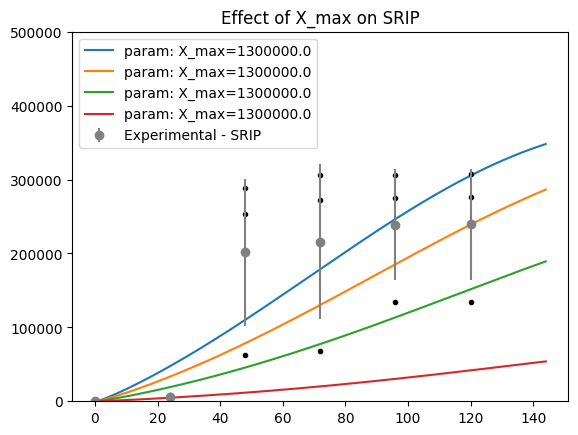

In [37]:
results = []

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for param in params:
    P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t = param
    results.append(solve_ivp(model, [t_min, t_end], y0, args=(P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t), t_eval=np.linspace(t_min, t_end, 1000), method='RK45'))
    
    ax.plot(results[-1].t, results[-1].y[3], label=f'param: X_max={X_max}')

for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.', color='black')

ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray')

ax.set_title('Effect of X_max on SRIP')
ax.set_ylim(0, 5e5)
ax.legend()

## Ser

In [25]:
params = [
    # P,             X_max, Ser, K_Ser, k_DNA,          k_s,  k_dRNA, k_vp, K_RNA, k_t
    [math.log(2)/24, 1.3e6, 0.1, 1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.8e-2],
    [math.log(2)/24, 1.3e6, 0.5, 1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.8e-2],
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.8e-2],
    [math.log(2)/24, 1.3e6, 10,  1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.8e-2],
    ]

X_0 = 2e5
DNA_0 = 2.0 * 1e11 / X_0 * 0.8
RNA_0 = 0.0  # Okumura
SRIP_0 = 0.0  # SRIPの初期値を適切に設定してください
y0 = [X_0, DNA_0, RNA_0, SRIP_0] # X, DNA, RNA, SRIP

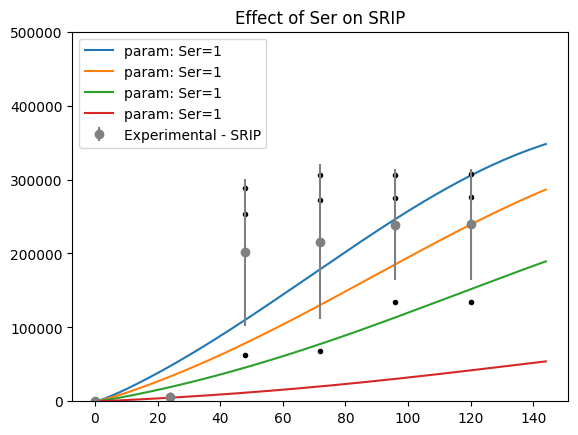

In [38]:
results = []

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for param in params:
    P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t = param
    results.append(solve_ivp(model, [t_min, t_end], y0, args=(P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t), t_eval=np.linspace(t_min, t_end, 1000), method='RK45'))
    
    ax.plot(results[-1].t, results[-1].y[3], label=f'param: Ser={Ser}')

for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.', color='black')

ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray')

ax.set_title('Effect of Ser on SRIP')
ax.set_ylim(0, 5e5)
ax.legend()

## k_vp

In [53]:
params = [
    # P,             X_max, Ser, K_Ser, k_DNA,          k_s,  k_dRNA, k_vp, K_RNA, k_t
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   2e-2, 2e3, 1.8e-2],
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1.5e-2, 2e3, 1.8e-2],
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.8e-2],
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   8e-3, 2e3, 1.8e-2],
    ]

X_0 = 2e5
DNA_0 = 2.0 * 1e11 / X_0 * 0.8
RNA_0 = 0.0  # Okumura
SRIP_0 = 0.0  # SRIPの初期値を適切に設定してください
y0 = [X_0, DNA_0, RNA_0, SRIP_0] # X, DNA, RNA, SRIP

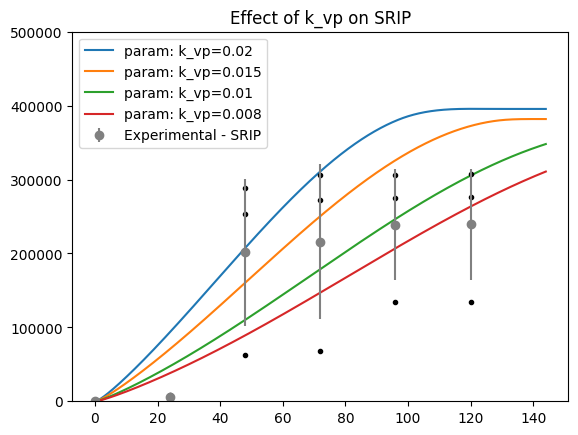

In [54]:
results = []

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for param in params:
    P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t = param
    results.append(solve_ivp(model, [t_min, t_end], y0, args=(P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t), t_eval=np.linspace(t_min, t_end, 1000), method='RK45'))
    
    ax.plot(results[-1].t, results[-1].y[3], label=f'param: k_vp={k_vp}')

for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.', color='black')

ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray')

ax.set_title('Effect of k_vp on SRIP')
ax.set_ylim(0, 5e5)
ax.legend()

## k_t

In [62]:
params = [
    # P,             X_max, Ser, K_Ser, k_DNA,          k_s,  k_dRNA, k_vp, K_RNA, k_t
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 2.8e-2],
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 2.5e-2],
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 2.2e-2],
    [math.log(2)/24, 1.3e6, 1,   1,     math.log(2)/24, 3e-3, 3e-2,   1e-2, 2e3, 1.9e-2],
    ]

X_0 = 2e5
DNA_0 = 2.0 * 1e11 / X_0 * 0.8
RNA_0 = 0.0  # Okumura
SRIP_0 = 0.0  # SRIPの初期値を適切に設定してください
y0 = [X_0, DNA_0, RNA_0, SRIP_0] # X, DNA, RNA, SRIP

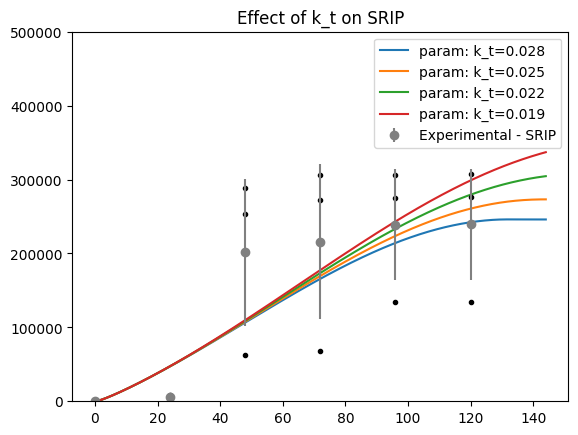

In [66]:
results = []

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for param in params:
    P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t = param
    results.append(solve_ivp(model, [t_min, t_end], y0, args=(P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t), t_eval=np.linspace(t_min, t_end, 1000), method='RK45'))
    
    ax.plot(results[-1].t, results[-1].y[3], label=f'param: k_t={k_t}')

for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.', color='black')

ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray')

ax.set_title('Effect of k_t on SRIP')
ax.set_ylim(0, 5e5)
ax.legend()

# scipyを用いたfitting

In [78]:
def model_for_fit(t, y, X_max, Ser, k_vp, k_t):
    X, DNA, RNA, SRIP = y
    if X < 0:
        X = 0
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser) - k_t * SRIP
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_s * DNA - k_dRNA * RNA
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X
    
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]

initial_param = [1.3e6, 1, 1e-2, 2.2e-2] # X_max, Ser, k_vp, k_t
bounds = [(0, 1.3e6), (0, 1e3), (0, 2e-2), (0, 2.2e-2)]

def fit_function(t, X_max, Ser, k_vp, k_t):
    sol = solve_ivp(model_for_fit, [min(t), max(t)], y0, args=(X_max, Ser, k_vp, k_t), t_eval=t, method='RK45')
    
    return sol.y[-1]

popt, _ = curve_fit(fit_function, t_data, data[:, 0], p0=initial_param, bounds=np.array(bounds).T)


print("最適化されたパラメータ:", popt)

最適化されたパラメータ: [7.59160414e+05 9.43332473e-01 1.89547479e-02 2.19379021e-02]


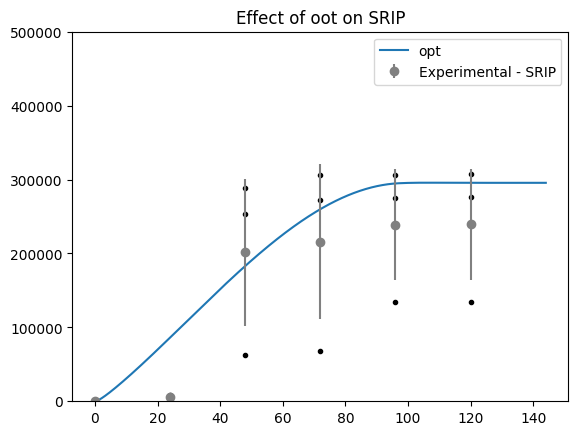

In [75]:
X_max, Ser, k_vp, k_t = popt

sol = solve_ivp(model, [t_min, t_end], y0, args=(P, X_max, Ser, K_ser, k_DNA, k_s, k_dRNA, k_vp, K_RNA, k_t), t_eval=np.linspace(t_min, t_end, 1000), method='RK45')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(sol.t, sol.y[3], label=f'opt')
for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.', color='black')

ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray')

ax.set_title('Effect of oot on SRIP')
ax.set_ylim(0, 5e5)
ax.legend()